# Testing Logistic Regression (Lab)

**Goal:** show how to test a trained logistic regression classifier, compute accuracy, and use the test results to tune a hyperparameter.

Running example: a model  that predicts whether a patient is diabetic (1) or healthy (0).

We will:

- Load a diabetes dataset and split into training and validation sets.
- Train logistic regression on the training set.
Test on the validation set: compute probabilities, convert to labels, and calculate accuracy.
Sweep the hyperparameters (learning rate [$\alpha$] and number of iterations [$\k$]) to see how validation accuracy changes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.special import expit
rng = np.random.default_rng(42)

## Part 1: Load the dataset

We will play with the following dataset from kaggle (https://www.kaggle.com/code/saijeevanbattiprolu/logistic-regression-on-diabetes/notebook). The feature matrix has the following predictors:

- Pregnancies: Number of times pregnant
- Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- BloodPressure: Diastolic blood pressure (mm Hg)
- SkinThickness: Triceps skin fold thickness (mm)
- Insulin: 2-Hour serum insulin (mu U/ml)
- BMI: Body mass index (weight in kg/(height in m)^2)
- DiabetesPedigreeFunction: Diabetes pedigree function
- Age: Age (years)
- Outcome: Class variable (1 for diabetic, 0 for healthy)

Please feel free to experiment with your own dataset for binary classification.

In [20]:
data = pd.read_csv("diabetes.csv")
data.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


For simplicity's sake and reproducibility, we will use a built-in function in scikit-learn to split our dataset into train and validation sets:

In [22]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

X_train, X_val, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

Let's code our simple logistic regression from scratch (sigmoid, and gradient descent).

In [23]:
def sigmoid(z):
    # return 1.0 / (1.0 + np.exp(-z))
    return expit(z)    
#
m, d = X_train.shape
w = np.zeros(d)
b = 0.0
lr = 0.1
n_iter = 2000

for _ in range(n_iter):
    # compute z
    z = X_train @ w + b
    # compute probabilities P(y=1|x)
    a = sigmoid(z)                                
    # compute gradients
    dw = (X_train.T @ (a - y_train)) / m          
    db = np.sum(a - y_train) / m
    # adjust weights and b
    w -= lr * dw
    b -= lr * db
# P(y=1|x) on validation set
y_prob = sigmoid(X_val @ w + b)                   

In [24]:
y_prob.tail(5)

355    0.0
534    0.0
344    0.0
296    0.0
462    0.0
dtype: float64

In [26]:
# Convert probabilities to predicted labels with a 0.5 threshold
y_pred = (y_prob >= 0.5).astype(int)
print(y_pred)
# Accuracy = (# correct predictions) / m
m_val = y_test.shape[0]
correct = int(np.sum(y_pred == y_test))
accuracy = correct / m_val

print(f"Validation accuracy: {accuracy:.3f}  (correct: {correct}/{m_val})")

668    0
324    0
624    0
690    0
473    0
      ..
355    0
534    0
344    0
296    0
462    0
Length: 154, dtype: int64
Validation accuracy: 0.649  (correct: 100/154)


## Part 2: Tune the learning rate

In [27]:
# generate a set of numbers from 1e-4 to 1.0
lr_space = np.logspace(-4, 0, 9)   
print(lr_space)
accs = []
for lr in lr_space:
    print (f"Current lr≈ {lr:.3g}")
    m, d = X_train.shape
    w = np.zeros(d)
    b = 0.0
    n_iter = 2000
    for _ in range(n_iter):
        # compute z
        z = X_train @ w + b
        # compute probabilities 
        a = sigmoid(z)                                
        # compute gradients
        dw = (X_train.T @ (a - y_train)) / m          
        db = np.sum(a - y_train) / m
        # update weights and intercept
        w -= lr * dw
        b -= lr * db
    # testing process using validation set
    # compute zigmoid for probabilities
    prob = sigmoid(X_val @ w + b)
    # compute predictions from probabilities
    pred = (prob >= 0.5).astype(int)
    # compute accuracy and append
    m_val = y_test.shape[0]
    correct = int(np.sum(pred == y_test))
    accuracy = correct / m_val
    accs.append(accuracy)

[1.00000000e-04 3.16227766e-04 1.00000000e-03 3.16227766e-03
 1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00]
Current lr≈ 0.0001
Current lr≈ 0.000316
Current lr≈ 0.001
Current lr≈ 0.00316
Current lr≈ 0.01
Current lr≈ 0.0316
Current lr≈ 0.1
Current lr≈ 0.316
Current lr≈ 1


In [28]:
# find the best accuracy
best_idx = int(np.argmax(accs))
best_lr = lr_space[best_idx]
best_acc = float(accs[best_idx])
print(f"Best learning rate ≈ {best_lr:.3g} with validation accuracy {best_acc:.3f}")

Best learning rate ≈ 0.0316 with validation accuracy 0.714


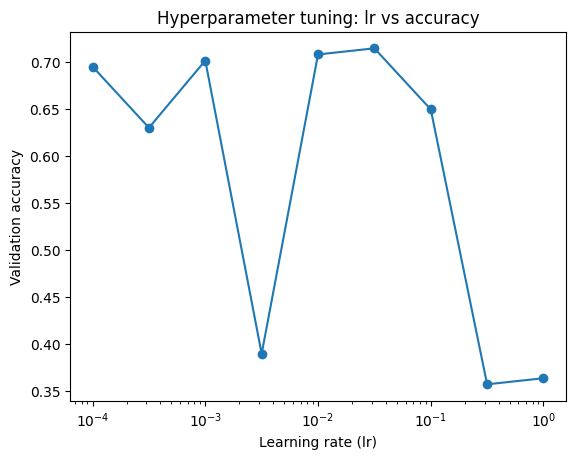

In [29]:
plt.figure()
plt.semilogx(lr_space, accs, marker="o")
plt.xlabel("Learning rate (lr)")
plt.ylabel("Validation accuracy")
plt.title("Hyperparameter tuning: lr vs accuracy")
plt.show()

## Part 3: Tune the number of iterations (k)

We can repeat the exercise, but now fixing the lr to 0.0316 and sweeping number of iteration candidates.

In [30]:
n_iter_space = [200, 500, 1000, 2000, 5000 ]
print(n_iter_space)
accs2 = []

for n_iter in n_iter_space:
    print (f"Current number of iterations≈ {n_iter:.3g}")
    m, d = X_train.shape
    w = np.zeros(d)
    b = 0.0
    lr = 0.0316
    for _ in range(n_iter):
        # compute z
        z = X_train @ w + b
        # compute probabilities
        a = sigmoid(z)                                # probabilities P(y=1|x)
        # Compute gradients
        dw = (X_train.T @ (a - y_train)) / m          # <-- no + lam * w / m
        db = np.sum(a - y_train) / m
        # update weights and intercept with current lr
        w -= lr * dw
        b -= lr * db
    
    prob = sigmoid(X_val @ w + b)
    pred = (prob >= 0.5).astype(int)
    m_val = y_test.shape[0]
    correct = int(np.sum(pred == y_test))
    accuracy = correct / m_val
    accs2.append(accuracy)

[200, 500, 1000, 2000, 5000]
Current number of iterations≈ 200
Current number of iterations≈ 500
Current number of iterations≈ 1e+03
Current number of iterations≈ 2e+03
Current number of iterations≈ 5e+03


In [31]:
#find the best accuracy for the number of iterations
best_idx = int(np.argmax(accs2))
best_n_iter = n_iter_space[best_idx]
best_acc2 = float(accs2[best_idx])
print(f"Best number of iterations ≈ {best_n_iter:.3g} with validation accuracy {best_acc2:.3f}")

Best number of iterations ≈ 1e+03 with validation accuracy 0.701


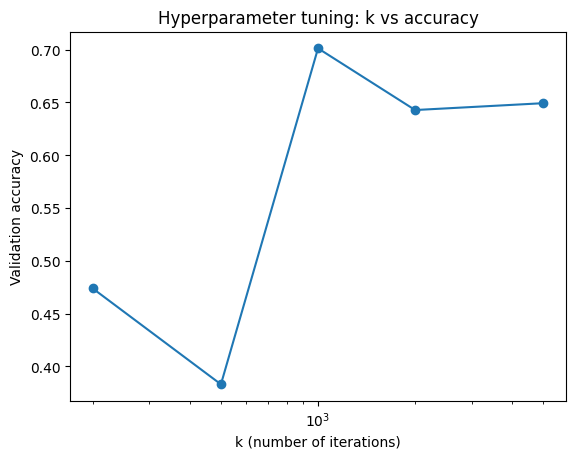

In [32]:
plt.figure()
plt.semilogx(n_iter_space, accs2, marker="o")
plt.xlabel("k (number of iterations)")
plt.ylabel("Validation accuracy")
plt.title("Hyperparameter tuning: k vs accuracy")
plt.show()

## Part 4: Homework

1. Using the built-in logistic regression in sci-kit, list the hyperparameter you can tune.
2. Code the hyperparameter tunning.